# Sentiment Analysis with Twitter Data

## Introduction
This Jupyter Notebook performs sentiment analysis on a Twitter dataset. We'll start by loading the dataset and preprocessing the text data.

## Data Preprocessing
We begin by importing necessary libraries and loading the Twitter dataset. The dataset contains information about tweets, including their sentiment labels (0 for negative, 4 for positive), tweet text, and other attributes.
## Importing required libraries


In [1]:
import pandas as pd
import warnings
import statsmodels.graphics.regressionplots as sm
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
warnings.filterwarnings(action='once')
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
import statsmodels.formula.api as smf
import seaborn as sns
import pylab
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as dt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

/Users/clara/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/clara/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/clara/opt/anaconda3/lib/python3.9/site-packages/seaborn/cm.py:1582: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/Users/clara/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmat

In [2]:
df = pd.read_csv('twitter.csv', encoding='latin1')
df.columns = ["Target","Id", "Date", "Query", "Username", "Tweet"]


df = df.reset_index()
df.head()

,index,Target,Id,Date,Query,Username,Tweet
0,0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


We then define a function for text preprocessing. This function performs tasks such as lowercasing, tokenization, stop word removal, punctuation removal, and stemming. It's applied to clean the tweet text and store it in a new column called "Cleaned_Tweet."

In [3]:
import nltk
import re

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Tokenization
    words = text.split()
    
    # Stop Word Removal
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Punctuation Removal
    words = [re.sub(r'[^\w\s]', '', word) for word in words]
    
    # Stemming (you can use lemmatization if needed)
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    return ' '.join(words)

# Apply the preprocessing function to the 'Tweet' column in your DataFrame
df['Cleaned_Tweet'] = df['Tweet'].apply(preprocess_text)

# Display the cleaned DataFrame
print(df[['Tweet', 'Cleaned_Tweet']].head())


[nltk_data] Downloading package stopwords to /Users/clara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                               Tweet  \
0  is upset that he can't update his Facebook by ...   
1  @Kenichan I dived many times for the ball. Man...   
2    my whole body feels itchy and like its on fire    
3  @nationwideclass no, it's not behaving at all....   
4                      @Kwesidei not the whole crew    

                                       Cleaned_Tweet  
0  upset cant updat facebook text it might cri re...  
1  kenichan dive mani time ball manag save 50 res...  
2                    whole bodi feel itchi like fire  
3  nationwideclass no behav all im mad here cant ...  
4                                kwesidei whole crew  


In [4]:
def build_corpus(data):
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)
    return corpus

corpus = build_corpus(df['Cleaned_Tweet'])
print(corpus[1:10])

[['kenichan', 'dive', 'mani', 'time', 'ball', 'manag', 'save', '50', 'rest', 'go', 'bound'], ['whole', 'bodi', 'feel', 'itchi', 'like', 'fire'], ['nationwideclass', 'no', 'behav', 'all', 'im', 'mad', 'here', 'cant', 'see', 'there'], ['kwesidei', 'whole', 'crew'], ['need', 'hug'], ['loltrish', 'hey', 'long', 'time', 'see', 'ye', 'rain', 'bit', 'onli', 'bit', 'lol', '', 'im', 'fine', 'thank', '', 'how', ''], ['tatiana_k', 'nope'], ['twittera', 'que', 'muera', ''], ['spring', 'break', 'plain', 'citi', 'snow']]


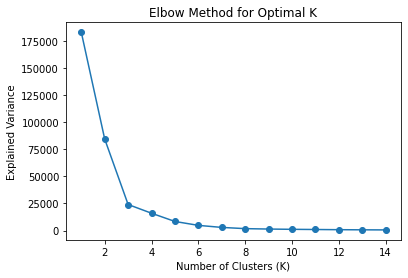

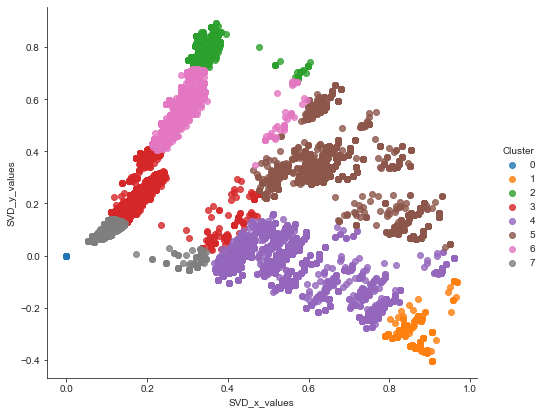

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Fit a 2D Truncated SVD model to the TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=10)
X = vectorizer.fit_transform(df['Cleaned_Tweet'])
svd = TruncatedSVD(n_components=2)
SVD_result = svd.fit_transform(X)  # Define SVD_result here

# Create a list to store the explained variance
explained_variance = []

# Define a range of K values (number of clusters) to try
k_values = range(1, 15)  # You can adjust the range as needed

# Fit K-Means for each K and calculate the explained variance
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(SVD_result)
    explained_variance.append(kmeans.inertia_)

# Plot the explained variance for different K values
plt.plot(k_values, explained_variance, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Explained Variance')
plt.title('Elbow Method for Optimal K')
plt.show()

# Add SVD components to your DataFrame
df['SVD_x_values'] = SVD_result[:, 0]
df['SVD_y_values'] = SVD_result[:, 1]

# Now df contains the SVD data alongside your original data
import seaborn as sns
from matplotlib import pyplot as plt
# You can choose the number of clusters based on your dataset
num_clusters = 8

kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(SVD_result)  # Use SVD_result for clustering
cluster_labels = kmeans.predict(SVD_result)
df['Cluster'] = cluster_labels

sns.set_style('ticks')
fig = sns.lmplot(x='SVD_x_values', y='SVD_y_values',
                 data=df,
                 fit_reg=False,
                 legend=True,
                 hue='Cluster')  # Assuming you want to color the points by cluster

fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()


## Exploratory Data Analysis

Now that we have preprocessed the data, let's explore it. We'll create word clouds to visualize the most frequent words in both positive and negative tweets.

### Word Cloud for Positive Sentiment


/Users/clara/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/clara/opt/anaconda3/lib/python3.9/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))
/Users/clara/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


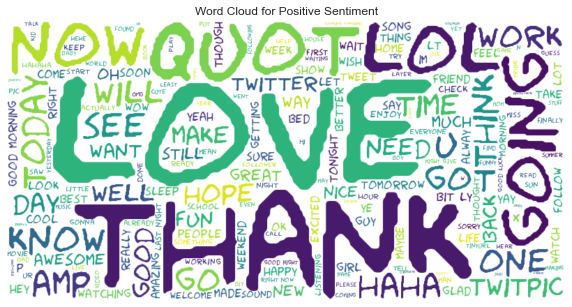

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter the positive sentiment tweets (where target == 4)
positive_tweets = df[df['Target'] == 4]['Tweet'].str.cat(sep=' ')

# Create the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white',font_path="/Users/clara/Desktop/Humor-Sans.ttf").generate(positive_tweets)

# Display the WordCloud in the Jupyter Notebook
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')
plt.show()


### Word Cloud for Negative Sentiment


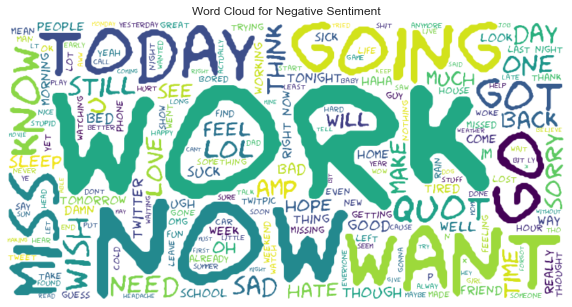

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter the positive sentiment tweets (where target == 4)
negative_tweets = df[df['Target'] == 0]['Tweet'].str.cat(sep=' ')

# Create the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white',font_path="/Users/clara/Desktop/Humor-Sans.ttf").generate(negative_tweets)

# Display the WordCloud in the Jupyter Notebook
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')
plt.show()

### Does clean prepossed data create more accurate word clouds?
Yes!

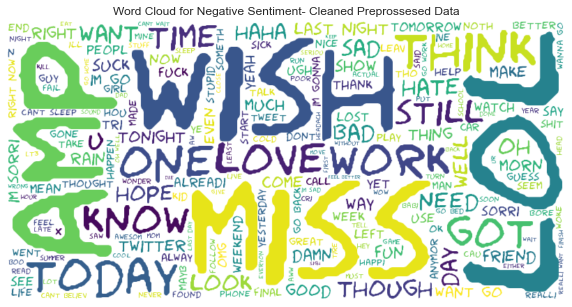

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter the positive sentiment tweets (where target == 4)
negative_tweets = df[df['Target'] == 0]['Cleaned_Tweet'].str.cat(sep=' ')

# Create the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white',font_path="/Users/clara/Desktop/Humor-Sans.ttf").generate(negative_tweets)

# Display the WordCloud in the Jupyter Notebook
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment- Cleaned Preprossesed Data')
plt.axis('off')
plt.show()

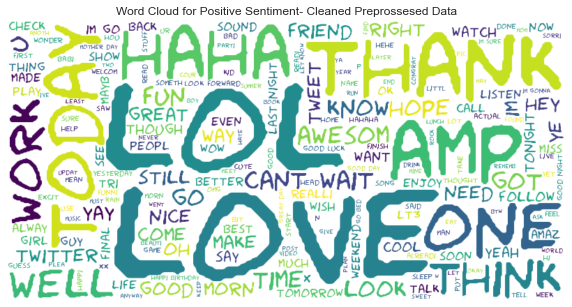

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter the positive sentiment tweets (where target == 4)
positive_tweets = df[df['Target'] == 4]['Cleaned_Tweet'].str.cat(sep=' ')

# Create the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white',font_path="/Users/clara/Desktop/Humor-Sans.ttf").generate(positive_tweets)

# Display the WordCloud in the Jupyter Notebook
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment- Cleaned Preprossesed Data')
plt.axis('off')
plt.show()

## Sentiment Classification

Next, we'll build and evaluate machine learning models to classify sentiment. We use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to convert text data into numerical features.

### Model Training and Evaluation
We train and evaluate several classification models using accuracy as the evaluation metric. Models include Logistic Regression, Naive Bayes, k-Nearest Neighbors, and Support Vector Classifier.

In [12]:
samples_per_class = 50000
balanced_df = df.groupby('Target').apply(lambda x: x.sample(samples_per_class)).reset_index(drop=True)

In [13]:
from sklearn.model_selection import train_test_split

X = balanced_df['Tweet']
y = balanced_df['Target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the number of features as needed
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

In [15]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(),
}

for name, model in models.items():
    model.fit(X_train_vectorized, y_train)
    predictions = model.predict(X_val_vectorized)
    accuracy = accuracy_score(y_val, predictions)
    print(f'{name} Accuracy: {accuracy}')

Logistic Regression Accuracy: 0.78085
Naive Bayes Accuracy: 0.7618
KNN Accuracy: 0.5831
SVC Accuracy: 0.79065


/Users/clara/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


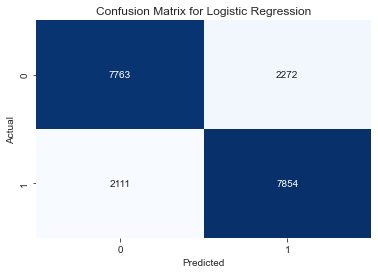

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     10035
           4       0.78      0.79      0.78      9965

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



/Users/clara/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


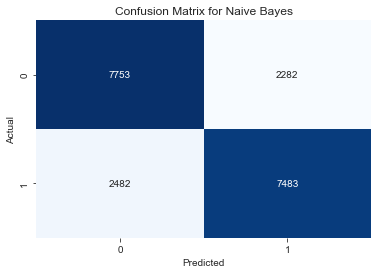

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76     10035
           4       0.77      0.75      0.76      9965

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



/Users/clara/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


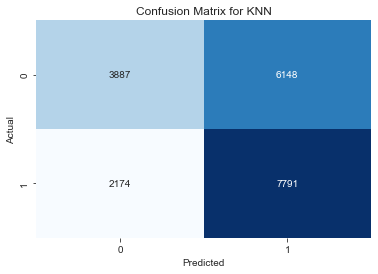

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.64      0.39      0.48     10035
           4       0.56      0.78      0.65      9965

    accuracy                           0.58     20000
   macro avg       0.60      0.58      0.57     20000
weighted avg       0.60      0.58      0.57     20000



/Users/clara/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


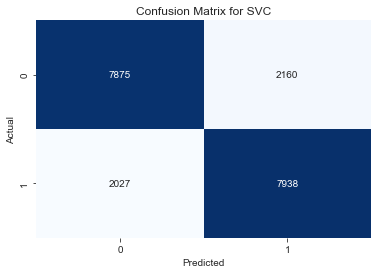

Classification Report for SVC:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     10035
           4       0.79      0.80      0.79      9965

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot the confusion matrix and display classification report
def plot_confusion_matrix_and_report(model, X_val_vectorized, y_val, model_name):
    predictions = model.predict(X_val_vectorized)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_val, predictions)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Display the classification report
    report = classification_report(y_val, predictions)
    print(f'Classification Report for {model_name}:\n{report}')

# Visualize confusion matrix and classification report for each model
for name, model in models.items():
    plot_confusion_matrix_and_report(model, X_val_vectorized, y_val, name)


In [17]:
X = balanced_df['Cleaned_Tweet']
y = balanced_df['Target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the number of features as needed
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(),
}

for name, model in models.items():
    model.fit(X_train_vectorized, y_train)
    predictions = model.predict(X_val_vectorized)
    accuracy = accuracy_score(y_val, predictions)
    print(f'{name} Accuracy: {accuracy}')

Logistic Regression Accuracy: 0.7573
Naive Bayes Accuracy: 0.74305
KNN Accuracy: 0.60005
SVC Accuracy: 0.759


/Users/clara/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


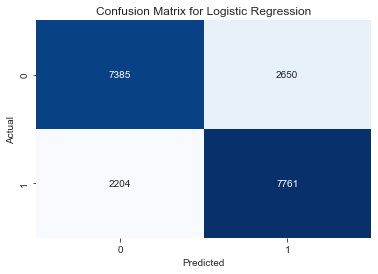

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75     10035
           4       0.75      0.78      0.76      9965

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



/Users/clara/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


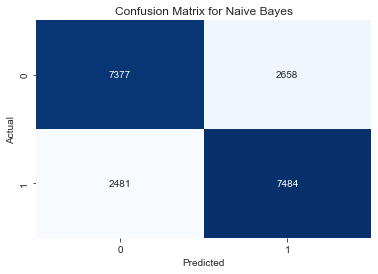

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74     10035
           4       0.74      0.75      0.74      9965

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000



/Users/clara/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


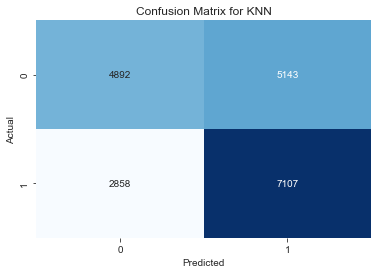

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.63      0.49      0.55     10035
           4       0.58      0.71      0.64      9965

    accuracy                           0.60     20000
   macro avg       0.61      0.60      0.59     20000
weighted avg       0.61      0.60      0.59     20000



/Users/clara/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


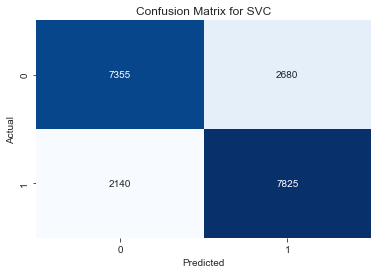

Classification Report for SVC:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     10035
           4       0.74      0.79      0.76      9965

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot the confusion matrix and display the classification report
def plot_confusion_matrix_and_report(model, X_val_vectorized, y_val, model_name):
    predictions = model.predict(X_val_vectorized)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_val, predictions)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Display the classification report
    report = classification_report(y_val, predictions)
    print(f'Classification Report for {model_name}:\n{report}')

# Visualize confusion matrix and classification report for each model
for name, model in models.items():
    plot_confusion_matrix_and_report(model, X_val_vectorized, y_val, name)


## Clustering Analysis

Finally, we perform clustering analysis to group similar tweets together. We use K-Means clustering to identify clusters and visualize them using word clouds.



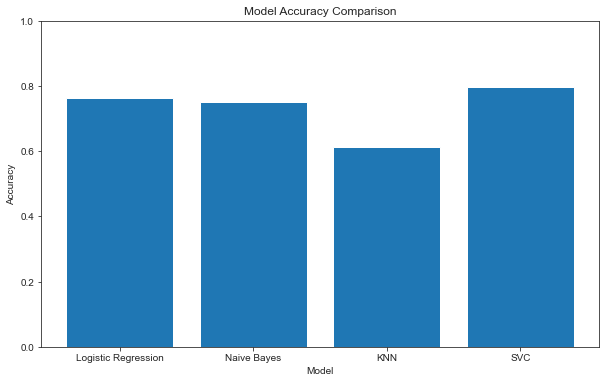

In [20]:
import matplotlib.pyplot as plt

model_names = ['Logistic Regression', 'Naive Bayes', 'KNN', 'SVC']
accuracies = [0.7619, 0.7504, 0.612, 0.79555]  # Replace with your actual accuracy scores

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.show()


# Conclusion

In this notebook, we've performed sentiment analysis on Twitter data. We preprocessed the text, visualized frequent words, and built classification models and clustering analysis to gain insights into the data.

This is just a brief overview of the analysis. For a detailed walkthrough, refer to the code and its explanations above.

/Users/clara/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/clara/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

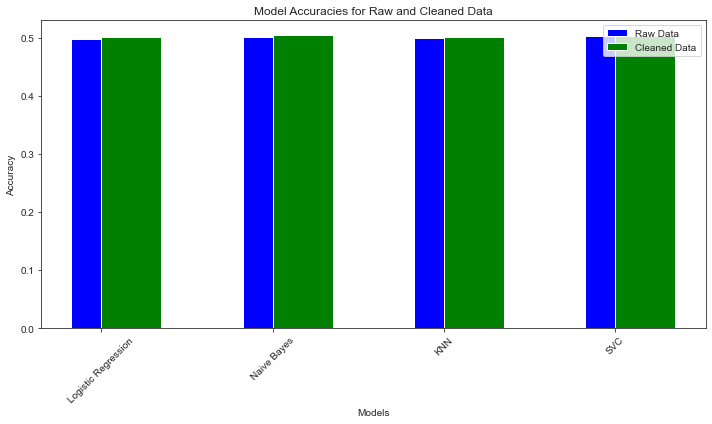

In [22]:
import matplotlib.pyplot as plt

# List of model names and their respective accuracies
model_names = list(models.keys())
accuracies_raw = []
accuracies_cleaned = []

for name, model in models.items():
    # Train and evaluate models on the raw data
    X_train_raw = df[df.index.isin(X_train.index)]['Tweet']
    X_val_raw = df[df.index.isin(X_val.index)]['Tweet']
    X_train_vectorized_raw = vectorizer.transform(X_train_raw)
    X_val_vectorized_raw = vectorizer.transform(X_val_raw)
    
    model.fit(X_train_vectorized_raw, y_train)
    predictions_raw = model.predict(X_val_vectorized_raw)
    accuracy_raw = accuracy_score(y_val, predictions_raw)
    accuracies_raw.append(accuracy_raw)

    # Train and evaluate models on the cleaned data
    X_train_cleaned = df[df.index.isin(X_train.index)]['Cleaned_Tweet']
    X_val_cleaned = df[df.index.isin(X_val.index)]['Cleaned_Tweet']
    X_train_vectorized_cleaned = vectorizer.transform(X_train_cleaned)
    X_val_vectorized_cleaned = vectorizer.transform(X_val_cleaned)
    
    model.fit(X_train_vectorized_cleaned, y_train)
    predictions_cleaned = model.predict(X_val_vectorized_cleaned)
    accuracy_cleaned = accuracy_score(y_val, predictions_cleaned)
    accuracies_cleaned.append(accuracy_cleaned)

# Plot the accuracies
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(model_names))

plt.bar(index, accuracies_raw, bar_width, label='Raw Data', color='b', align='center')
plt.bar(index, accuracies_cleaned, bar_width, label='Cleaned Data', color='g', align='edge')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies for Raw and Cleaned Data')
plt.xticks(index, model_names, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
